In [16]:
using Revise, Plots, FFTW, LinearAlgebra, LaTeXStrings, Random, Distributions

In [17]:
includet("../../src/SparseSpikes.jl")
using .SparseSpikes

Define ground truth amplitudes and positions

In [18]:
domain = [0, 1]

x0 = [0.4, 0.7]
a0 = [1.5, -1.0]

μ0 = DiscreteMeasure(x0, a0)

DiscreteMeasure([0.4, 0.7], [1.5, -1.0], 1, 2)

In [43]:
# Define the number of Fourier coefficients
fc = 6
n = 2fc + 1

# Define noise level
noise_level = 0.1

# Seed for noise
Random.seed!(12)

TaskLocalRNG()

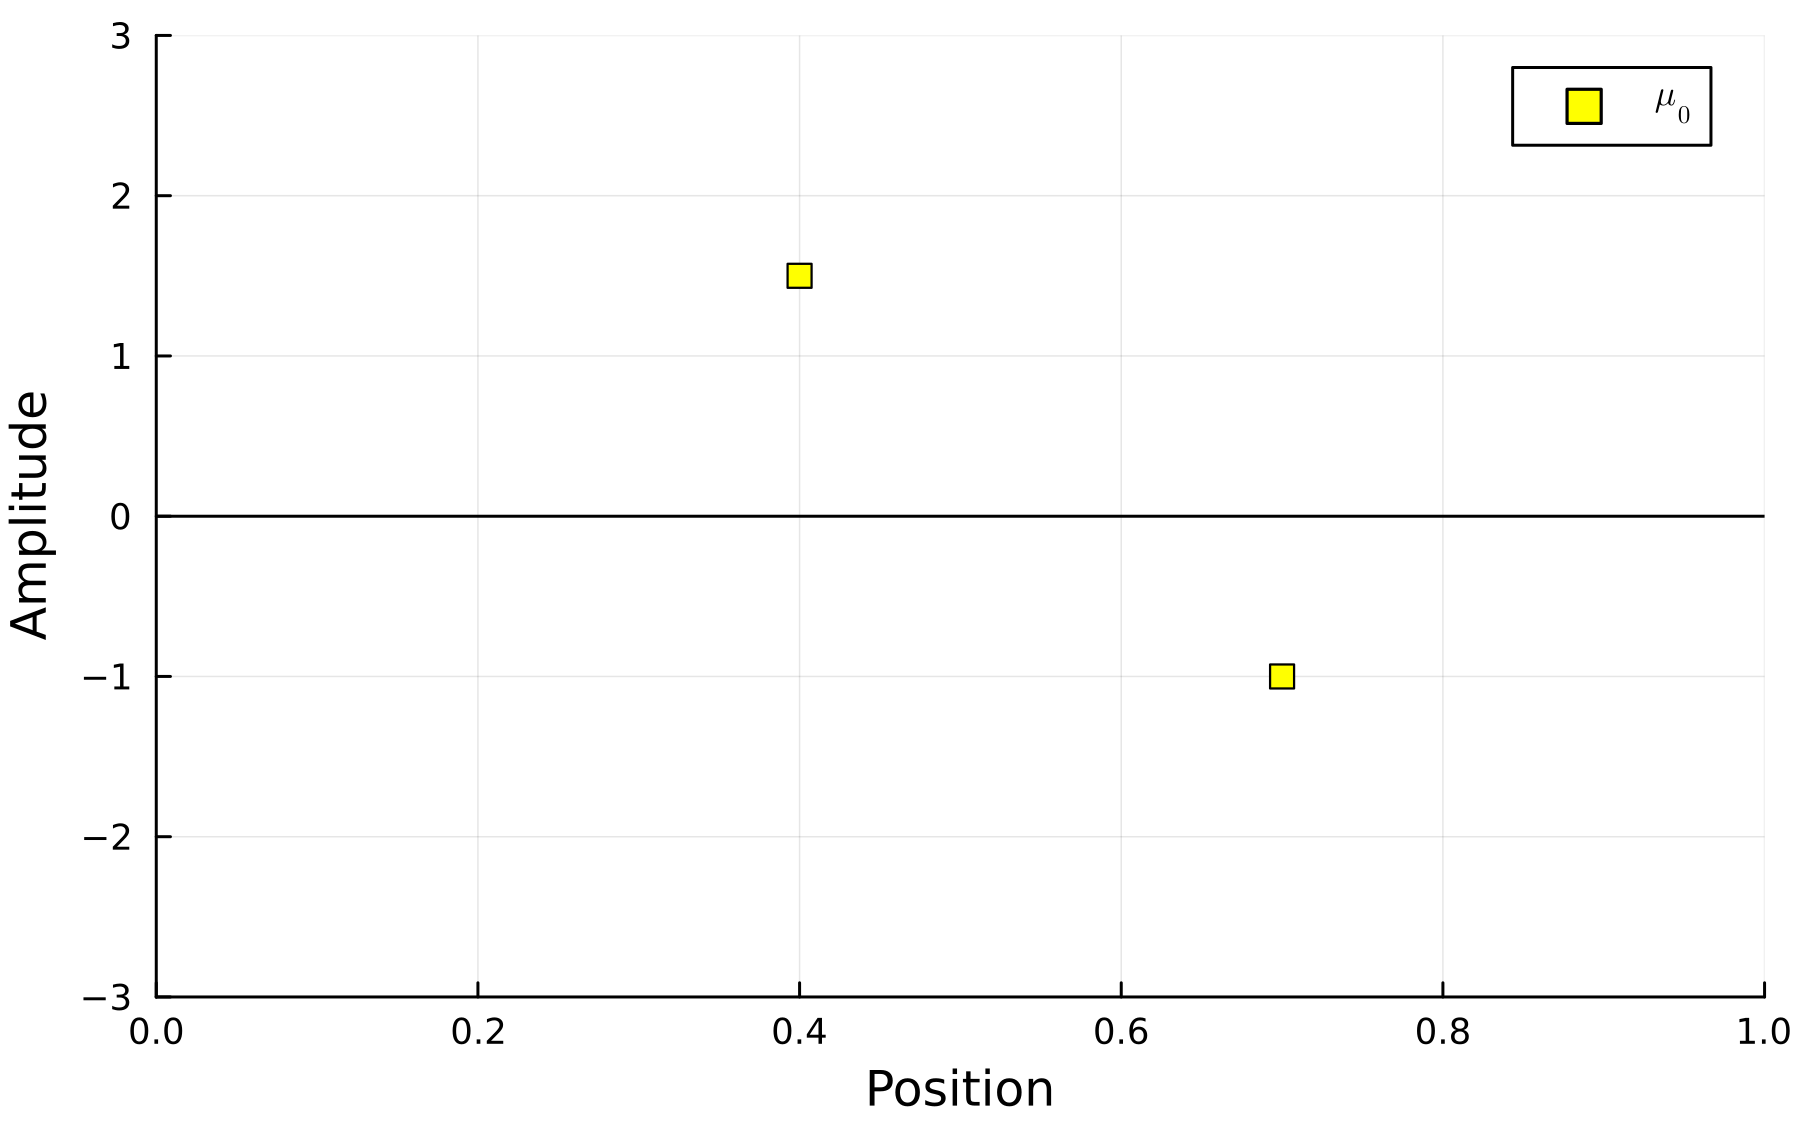

In [44]:
# Define the plot
num_points = 1000
plt_grid = range(domain..., length=(num_points + 1))
plot_size = (400, 250) .* 1.5
plt = plot(xlims=extrema(domain), ylims=(-3, 3), xlabel="Position", ylabel="Amplitude", legend=:topright, size=plot_size, dpi=300)
hline!(plt, [0], linestyle=:solid, color=:black, label="")

plot!(plt, μ0.x, μ0.a, seriestype=:scatter, color=:yellow, label=L"μ_0", marker=:square)

In [45]:
ops = fourier_operators_1D(fc, plt_grid)

Operators(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.2773500981126146, -6:6), var"#Φ#13"{var"#ϕ#12"{Float64, UnitRange{Int64}}}(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.2773500981126146, -6:6)), var"#adjΦ#14"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, UnitRange{Int64}}}}(0.0:0.001:1.0, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, UnitRange{Int64}}}(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.2773500981126146, -6:6))))

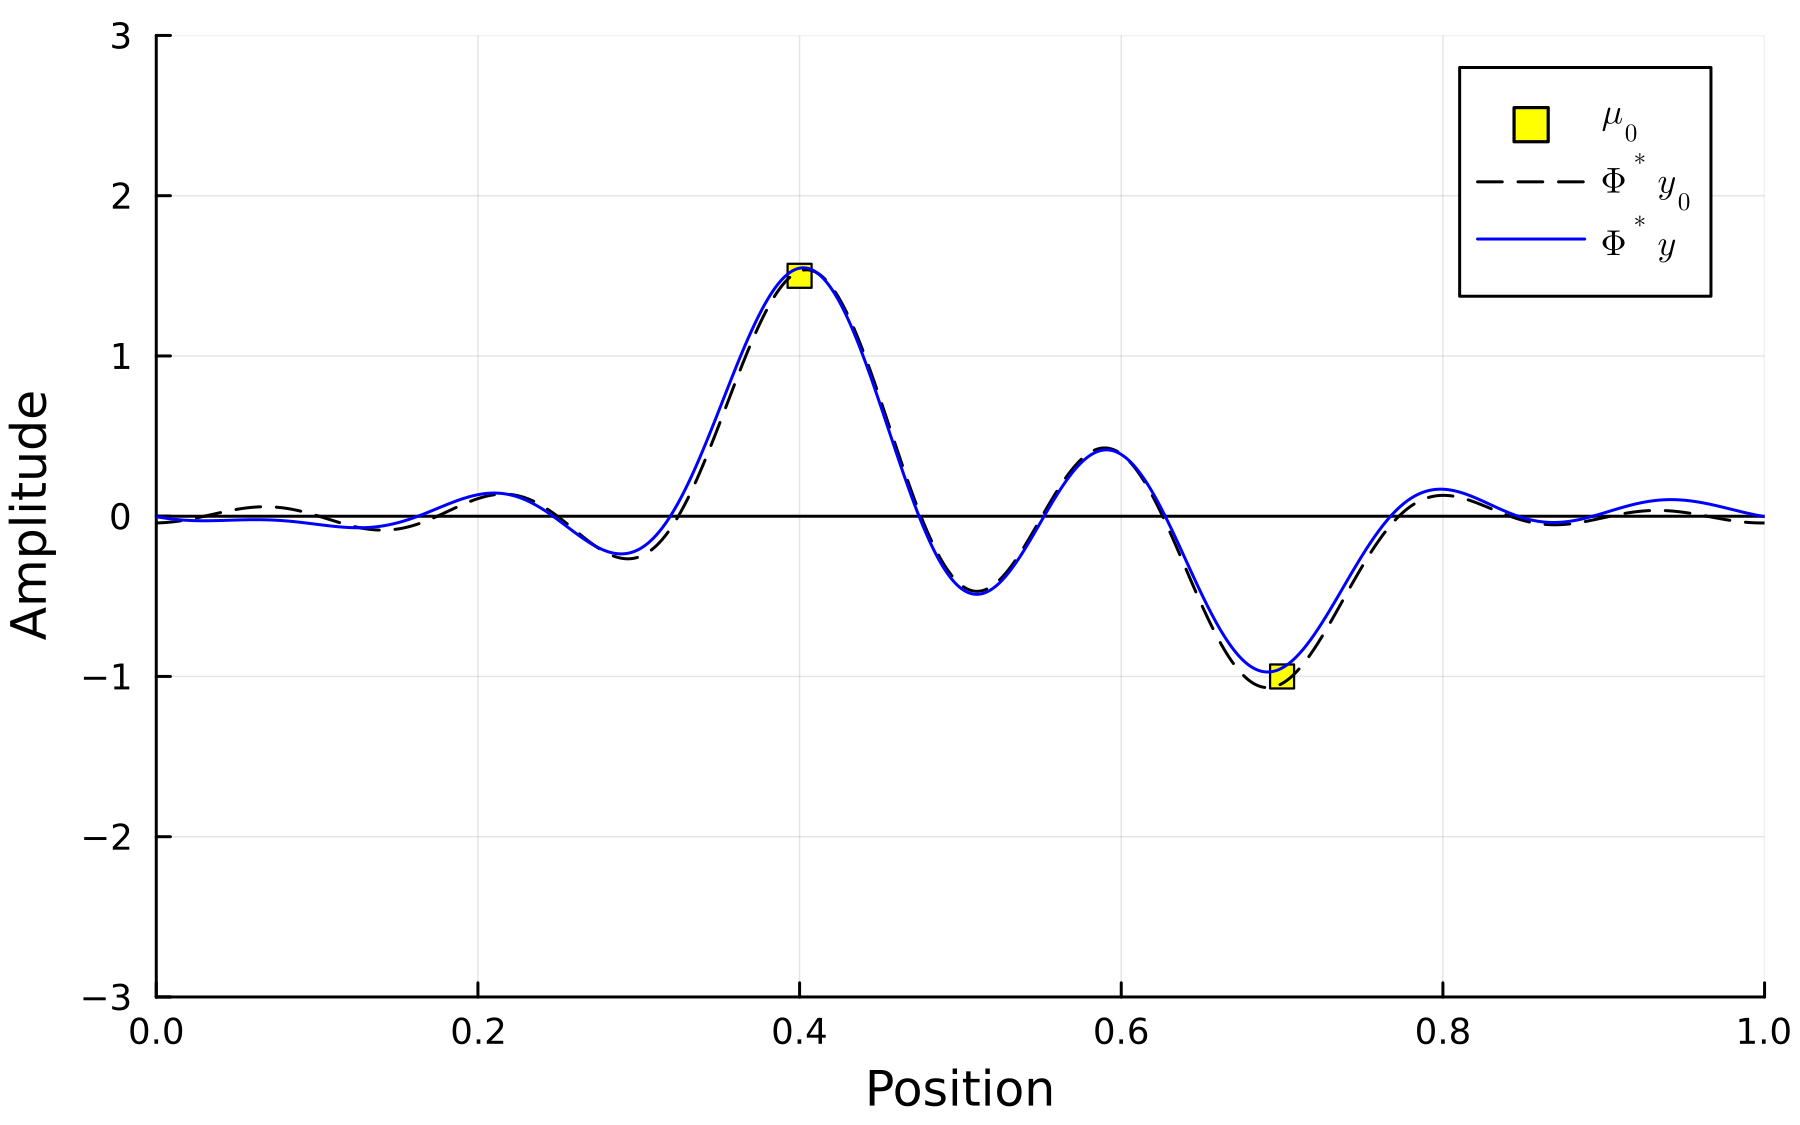

In [ ]:
# Calculate the observation y0 = Φμ0
y0 = ops.Φ(x0, a0)

# Add noise to the observation y = y0 + w
sigma = noise_level * norm(y0)
w = fftshift(fft(randn(length(y0))))
w = w / norm(w) * sigma
y = y0 + w

plt_obs = deepcopy(plt)

plot!(plt_obs, plt_grid, ops.adjΦ(y0), label=L"Φ^{\ast}y_0", color=:black, linestyle=:dash)
plot!(plt_obs, plt_grid, ops.adjΦ(y), label=L"Φ^{\ast}y", color=:blue)

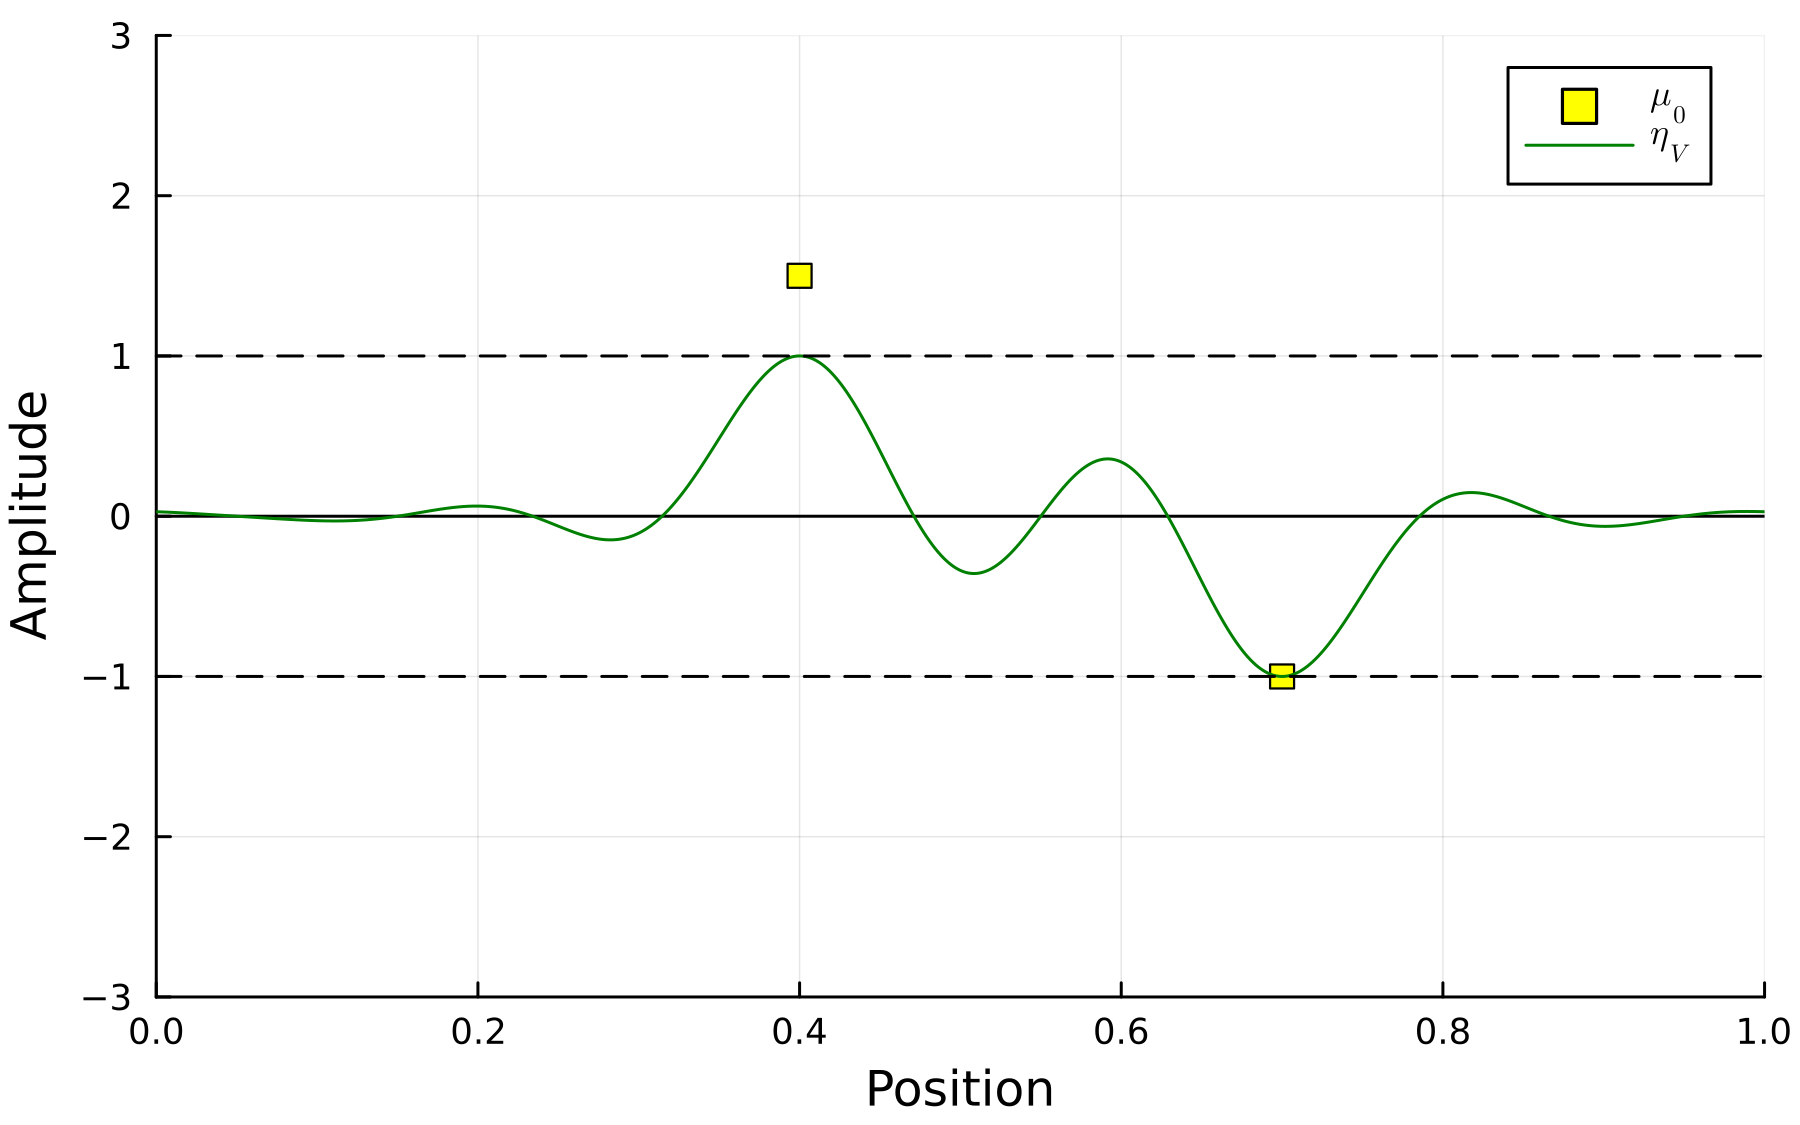

In [47]:
ηV = pre_certificate(μ0, ops)

plt_cert = deepcopy(plt)

plot!(plt_cert, plt_grid, ηV, label=L"η_V", color=:green)
hline!(plt_cert, [1, -1], linestyle=:dash, color=:black, label="")

## SDP

In [60]:
λ = 0.01

prob = BLASSO(y, ops, domain, λ)

prob_sdp = deepcopy(prob)

solve!(prob_sdp, :SDP)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 262             
  Affine conic cons.     : 1 (28 rows)
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 27              
  Matrix variables       : 1 (scalarized: 406)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - dual attempts          : 0             

BLASSO(ComplexF64[-0.380826276126692 - 0.024262351386144933im, 0.6967548578665611 - 0.0521069021272357im, -0.43122546792497557 - 0.020200747753913173im, -0.046055416687932296 + 0.22473303424225524im, 0.29814055611407464 - 0.5869997149507287im, -0.25036903639824065 + 0.47341449935740665im, 0.21643364719941535 + 0.0im, -0.25036903639824065 - 0.47341449935740665im, 0.29814055611407464 + 0.5869997149507287im, -0.046055416687932296 - 0.22473303424225524im, -0.43122546792497557 + 0.020200747753913173im, 0.6967548578665611 + 0.0521069021272357im, -0.380826276126692 + 0.024262351386144933im], Operators(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.2773500981126146, -6:6), var"#Φ#13"{var"#ϕ#12"{Float64, UnitRange{Int64}}}(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.2773500981126146, -6:6)), var"#adjΦ#14"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, UnitRange{Int64}}}}(0.0:0.001:1.0, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, Unit

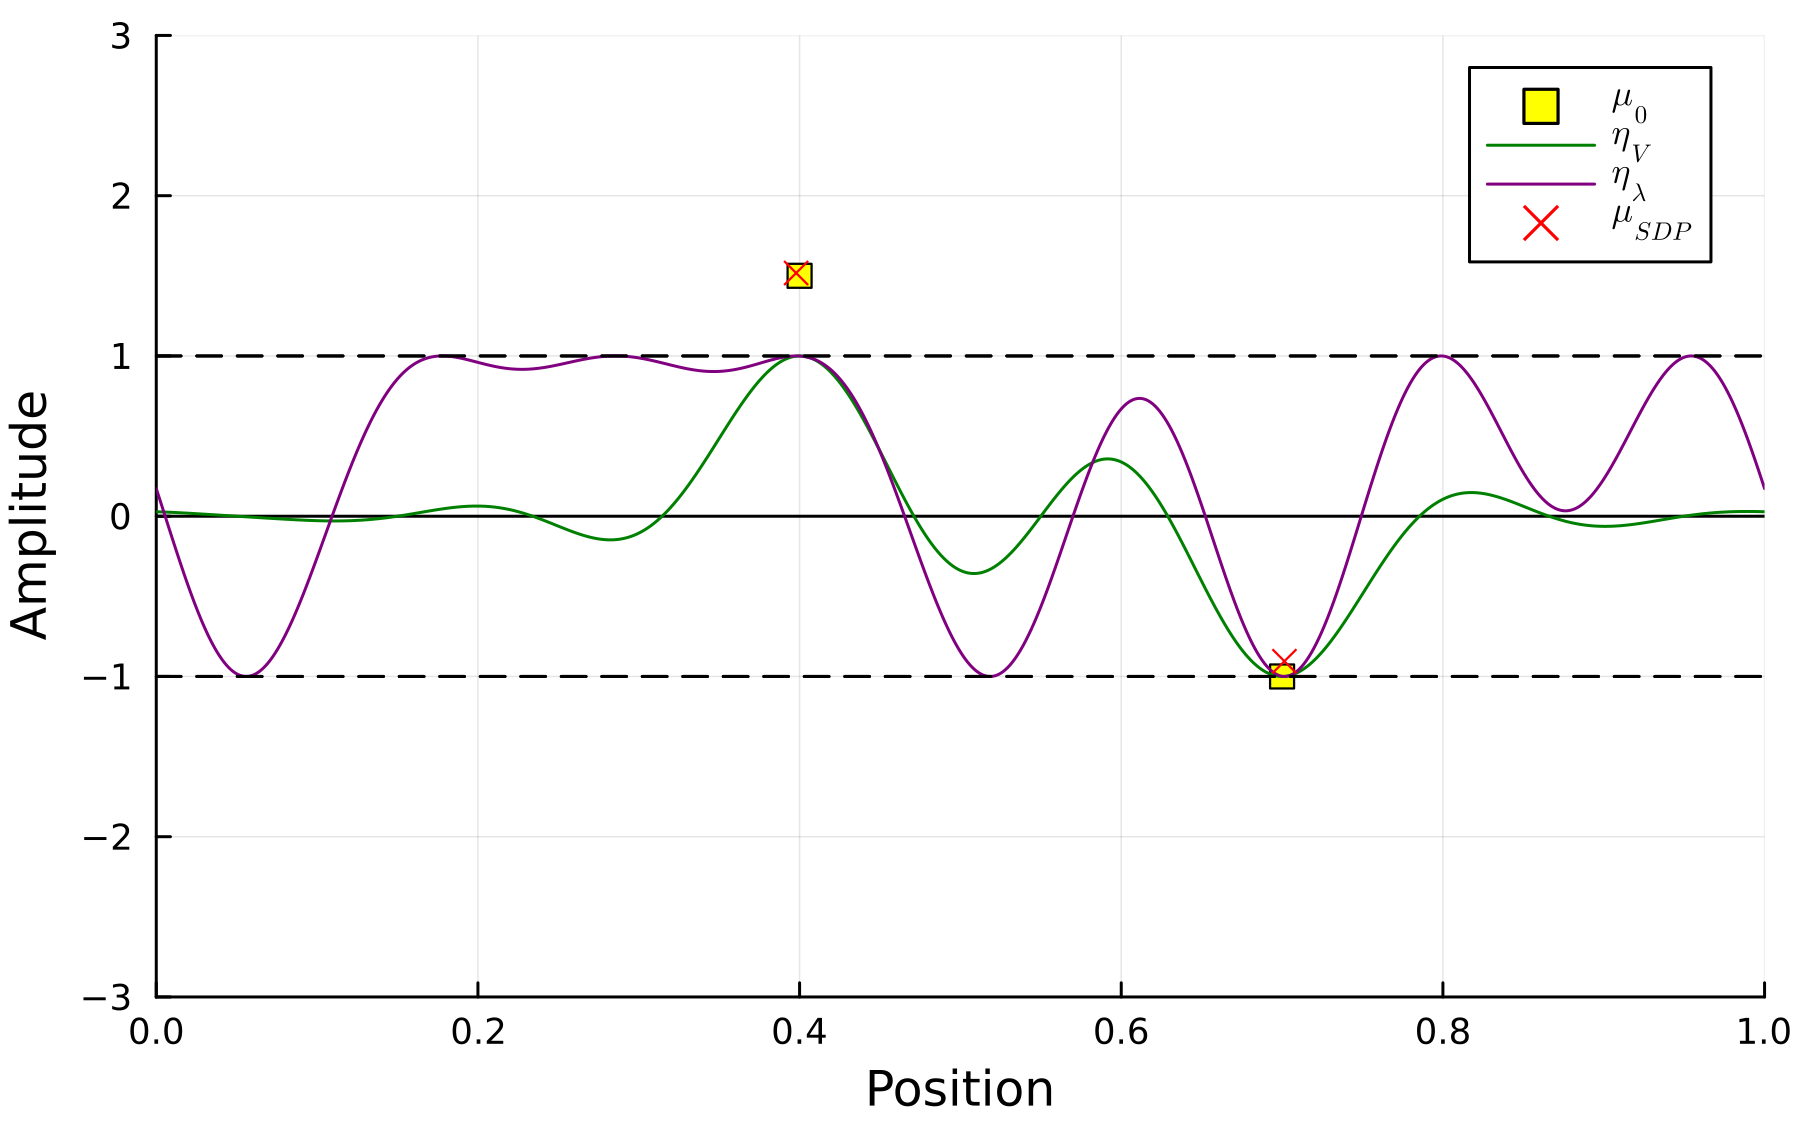

In [64]:
plt_sdp = deepcopy(plt_cert)

# dual polynomial
ηλ = ops.adjΦ(prob_sdp.p) * sqrt(n)
plot!(plt_sdp, plt_grid, ηλ, label=L"η_λ", color=:purple)
hline!(plt_sdp, [1, -1], linestyle=:dash, color=:black, label="")
plot!(plt_sdp, prob_sdp.μ.x, prob_sdp.μ.a, seriestype=:scatter, color=:red, label=L"μ_{SDP}", marker=:x)

## Sliding Frank-Wolfe

In [62]:
prob_sfw = deepcopy(prob)

solve!(prob_sfw, :SFW)

BLASSO(ComplexF64[-0.380826276126692 - 0.024262351386144933im, 0.6967548578665611 - 0.0521069021272357im, -0.43122546792497557 - 0.020200747753913173im, -0.046055416687932296 + 0.22473303424225524im, 0.29814055611407464 - 0.5869997149507287im, -0.25036903639824065 + 0.47341449935740665im, 0.21643364719941535 + 0.0im, -0.25036903639824065 - 0.47341449935740665im, 0.29814055611407464 + 0.5869997149507287im, -0.046055416687932296 - 0.22473303424225524im, -0.43122546792497557 + 0.020200747753913173im, 0.6967548578665611 + 0.0521069021272357im, -0.380826276126692 + 0.024262351386144933im], Operators(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.2773500981126146, -6:6), var"#Φ#13"{var"#ϕ#12"{Float64, UnitRange{Int64}}}(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.2773500981126146, -6:6)), var"#adjΦ#14"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, UnitRange{Int64}}}}(0.0:0.001:1.0, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, Unit

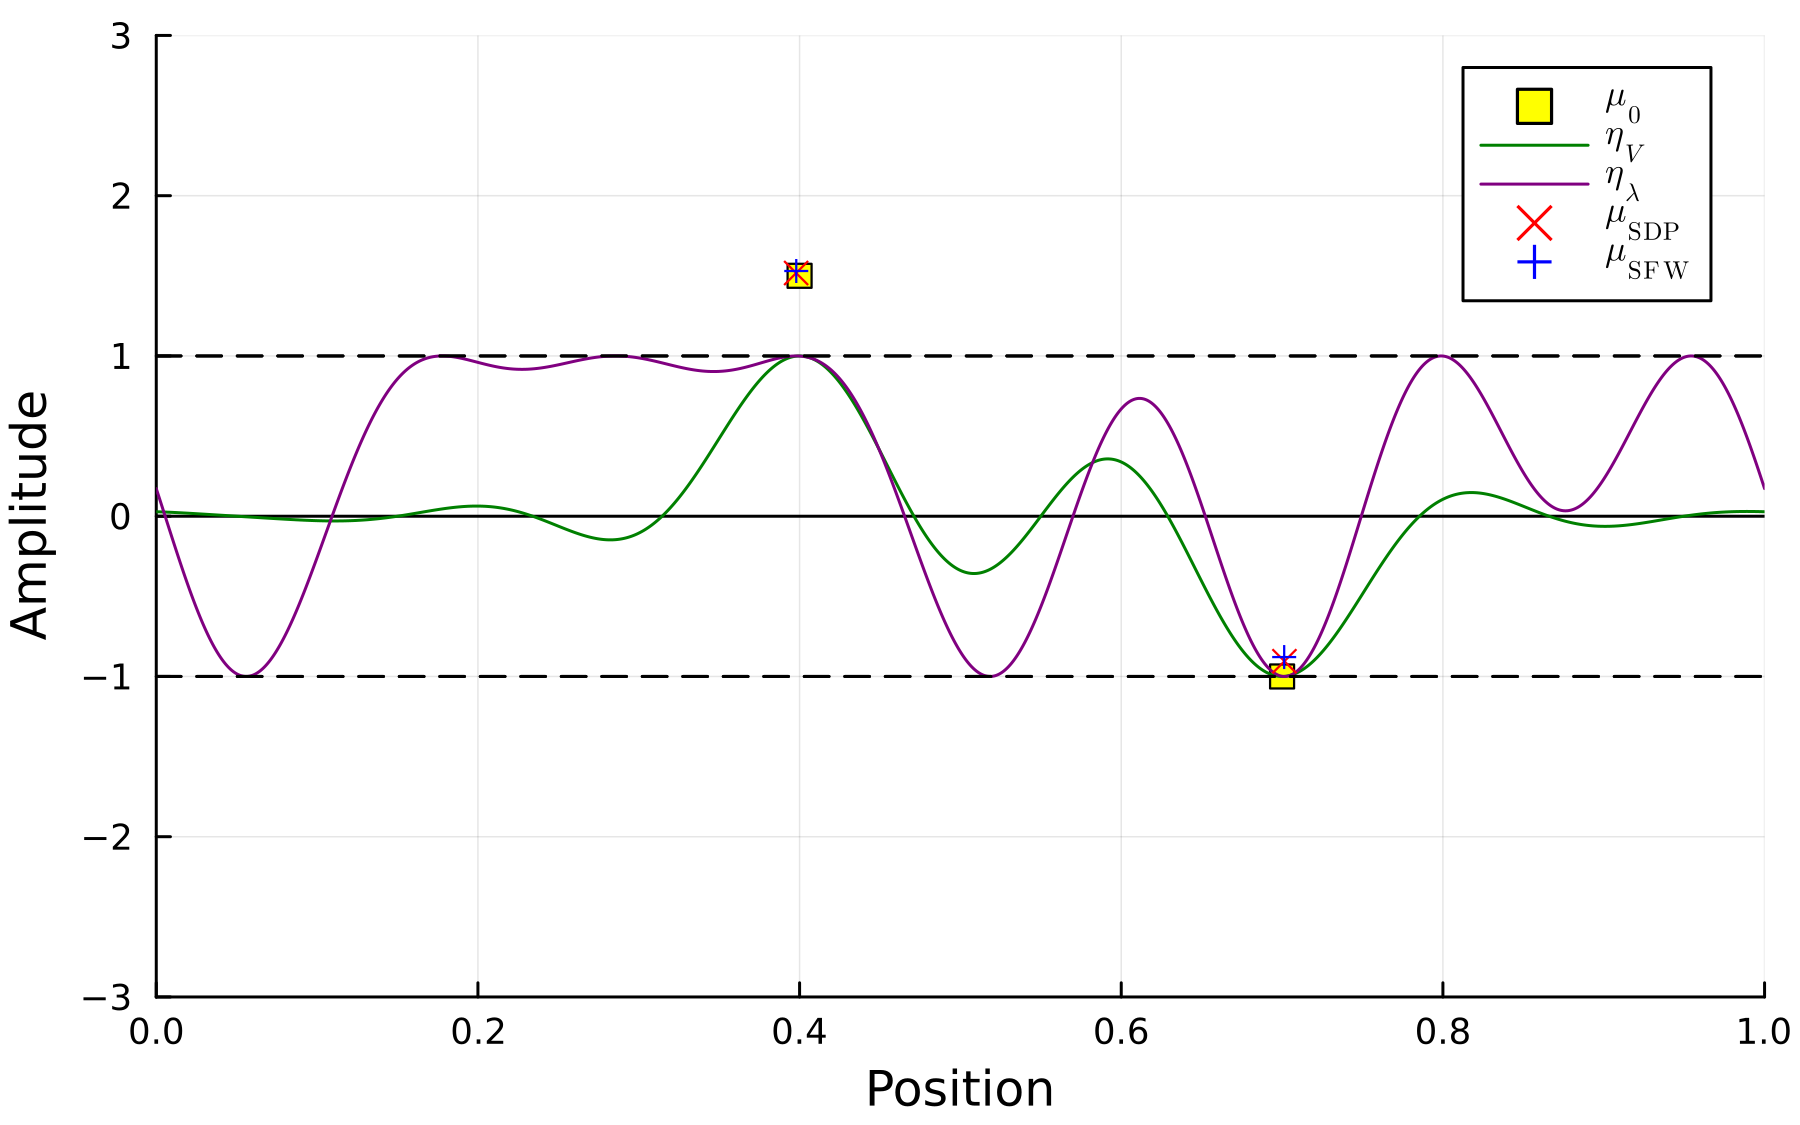

In [65]:
plt_sfw = deepcopy(plt_cert)

plot!(plt_sfw, plt_grid, ηλ, label=L"η_λ", color=:purple)
hline!(plt_sfw, [1, -1], linestyle=:dash, color=:black, label="")
plot!(plt_sfw, prob_sdp.μ.x, prob_sdp.μ.a, seriestype=:scatter, label=L"μ_\mathrm{SDP}", color=:red, marker=:x)
plot!(plt_sfw, prob_sfw.μ.x, prob_sfw.μ.a, seriestype=:scatter, label=L"μ_\mathrm{SFW}", color=:blue, marker=:cross)

In [68]:
savefig(plt_obs, "../../figures/Observation.svg")

"c:\\Users\\ladis\\OneDrive - University of Warwick\\Year 4\\Super resolution\\Codes\\SparseSpikes\\figures\\Observation.svg"

In [69]:
savefig(plt_sfw, "../../figures/SDPandSFW.svg")

"c:\\Users\\ladis\\OneDrive - University of Warwick\\Year 4\\Super resolution\\Codes\\SparseSpikes\\figures\\SDPandSFW.svg"